## Bank Marketing Campaign Prediction using Machine Learning

### Introduction

This project focuses on predicting whether a customer will subscribe to a bank term deposit based on demographic, financial, and campaign-related data.
The goal is to help banks optimize marketing strategies by identifying potential subscribers more effectively.

---
Importing necessary libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost

import warnings
warnings.filterwarnings('ignore')

- Reading the dataset

In [26]:
df = pd.read_csv('bank-full.csv', sep=';')

### 1. Data Inspection & Cleaning

In [27]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [28]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


### Dataset Overview
The dataset used is the Bank Marketing dataset, which contains customer details such as age, job, balance, loan status, contact method, and past campaign outcomes.
It consists of over 45,000 records with both numerical and categorical attributes.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [30]:
print(df.shape[0] , "rows")
print(df.shape[1], "columns")

45211 rows
17 columns


In [31]:
df.isna().sum()/len(df) * 100

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
y            0.0
dtype: float64

* ##### Count plot of y (Subscribed vs Not Subscribed)

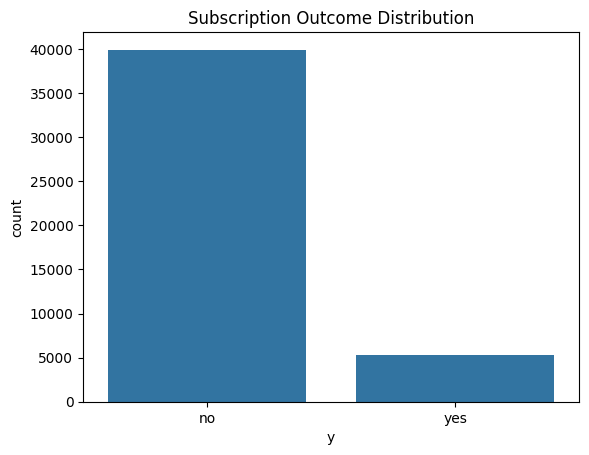

In [32]:
sns.countplot(x='y', data=df)
plt.title("Subscription Outcome Distribution")
plt.show()

Exploratory analysis revealed a strong class imbalance, with most customers not subscribing to the product.

In [33]:
df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [34]:
# Dropped the duration column because it is a post-call variable and would cause data leakage if used for prediction.
df = df.drop(columns=['duration'])

In [35]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [36]:
cols = df.select_dtypes(include=['object']).columns
# Identified categorical columns by selecting object-type features.

for col in cols:
    print(f"{col}: {df[col].nunique()} unique values", df[col].unique(), "\n")
# Reviewed the number of unique values in each categorical attribute to decide the appropriate encoding strategy.

job: 12 unique values ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital: 3 unique values ['married' 'single' 'divorced'] 

education: 4 unique values ['tertiary' 'secondary' 'unknown' 'primary'] 

default: 2 unique values ['no' 'yes'] 

housing: 2 unique values ['yes' 'no'] 

loan: 2 unique values ['no' 'yes'] 

contact: 3 unique values ['unknown' 'cellular' 'telephone'] 

month: 12 unique values ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

poutcome: 4 unique values ['unknown' 'failure' 'other' 'success'] 

y: 2 unique values ['no' 'yes'] 



In [37]:
cols_with_yes_no = ['default', 'housing', 'loan', 'y']
for col in cols_with_yes_no:
    df[col] = df[col].map({'yes': 1, 'no': 0})

* Converted binary categorical variables (default, housing, loan, and target y) from yes/no to numerical format (1/0).

In [38]:
df[cols_with_yes_no].isnull().sum()

# Checked for null values after mapping to ensure the transformation did not introduce missing data.

default    0
housing    0
loan       0
y          0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  int64 
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  int64 
 7   loan       45211 non-null  int64 
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  int64 
dtypes: int64(10), object(6)
memory usage: 5.5+ MB


### Job vs Subscription Rate

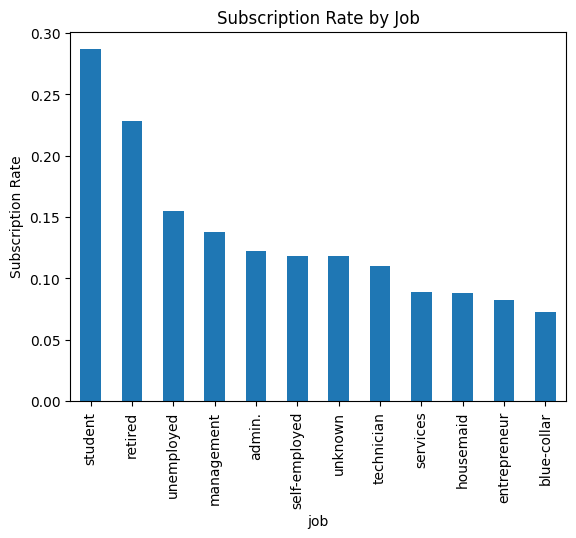

In [40]:
job_rate = df.groupby('job')['y'].mean().sort_values(ascending=False)
job_rate.plot(kind='bar')
plt.title("Subscription Rate by Job")
plt.ylabel("Subscription Rate")
plt.show()

* The visualization indicates that subscription rates vary significantly across job categories. Students and retired customers exhibit the highest subscription rates, while blue-collar and entrepreneurial groups show lower engagement. This suggests that occupational status influences customer responsiveness to marketing campaigns.

In [41]:
from sklearn.preprocessing import OneHotEncoder
# Used One-Hot Encoding to convert categorical variables into numerical form.

cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
# Dropped the first category to avoid the dummy variable trap and multicollinearity.
# Used handle_unknown='ignore' to safely handle unseen categories during prediction or deployment.

encoded_array = ohe.fit_transform(df[cat_cols])

encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(cat_cols), index=df.index)
# Converted the encoded output into a DataFrame with proper feature names for easier handling and interpretation.

* Other categorical variables were encoded using One-Hot Encoding to make them suitable for machine learning models.

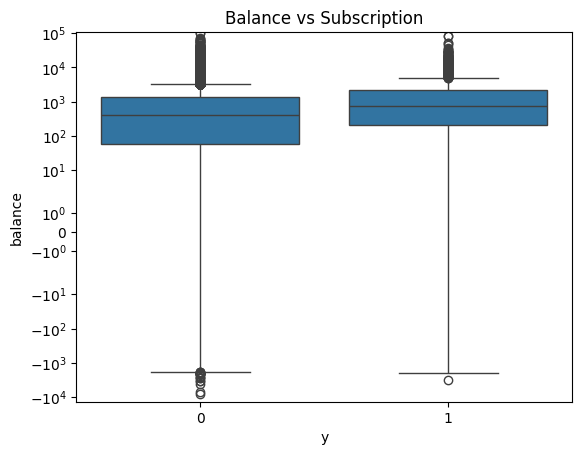

In [42]:
sns.boxplot(x='y', y='balance', data=df)
plt.yscale('symlog')  # optional, balances are skewed
plt.title("Balance vs Subscription")
plt.show()

* The boxplot of account balance versus subscription outcome shows that customers who subscribed generally maintain higher account balances, with a higher median and upper distribution compared to non-subscribers. Although the variable exhibits significant skewness and outliers, these values represent genuine customer behavior and were therefore retained.

* Customers with higher balances tend to subscribe more frequently, suggesting that financial stability influences campaign response. This pattern supports retaining balance as a key predictive feature.

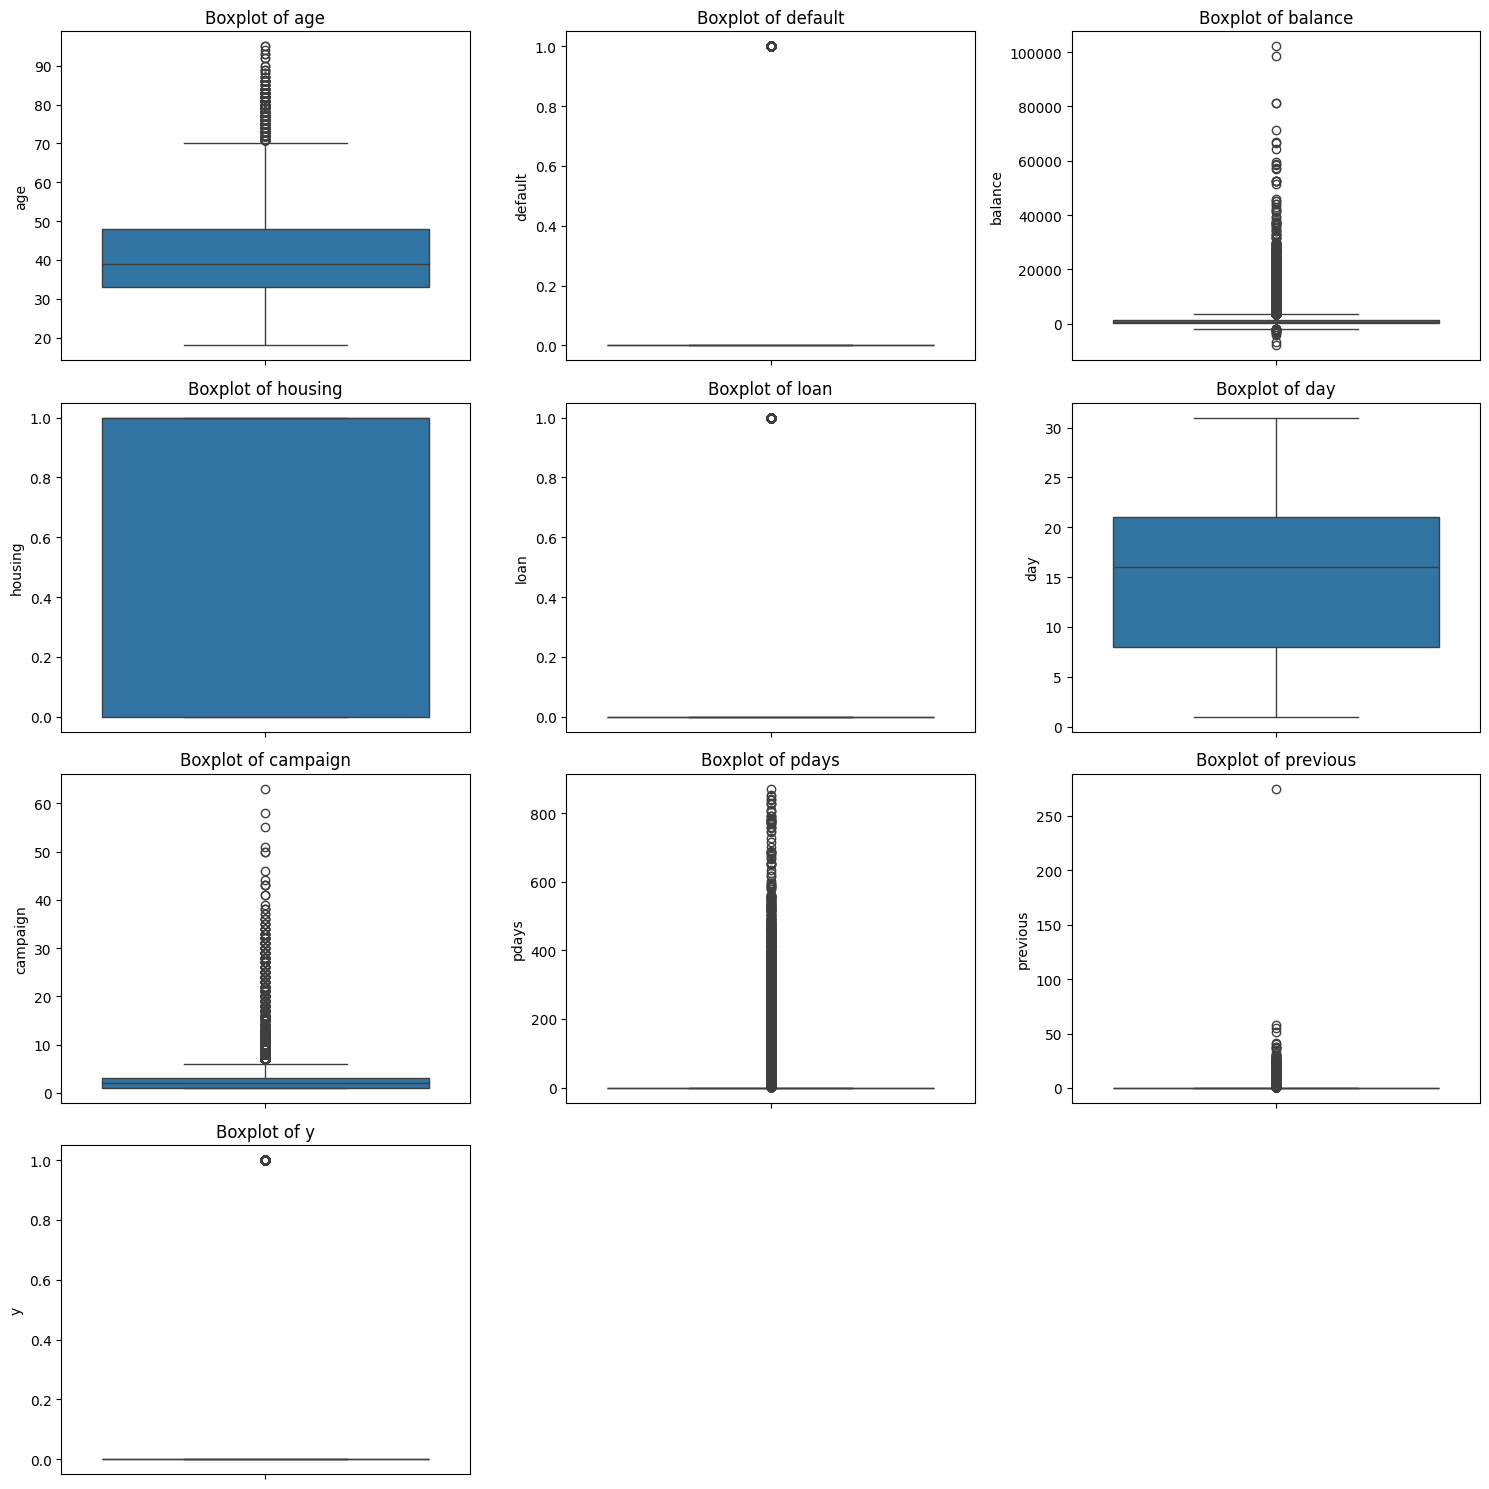

In [43]:
# Checking outliers in all numeric columns using boxplots 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

numeric_cols = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'y']

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Boxplot of {col}")

# Hide any unused subplots
for j in range(len(numeric_cols), 12):
    fig.delaxes(axes[j//3, j%3])

plt.tight_layout()
plt.show()

* Outliers weren't removed because they were representative of genuine customer behavior. 

In [44]:
df_numeric = df.drop(columns=cat_cols)
# Separated numerical and binary features by dropping the original categorical columns.

df_encoded = pd.concat([df_numeric, encoded_df], axis=1)
# Combined the numerical features with the one-hot encoded categorical features into a single dataset.
# Created a fully numerical, model-ready DataFrame suitable for machine learning algorithms.

df_encoded.head(2)

,age,default,balance,housing,loan,day,campaign,pdays,previous,y,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44,0,29,1,0,5,1,-1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
y = df_encoded['y']
x = df_encoded.drop(columns=['y'])

print(x.shape)
print(y.shape)

(45211, 41)
(45211,)


In [114]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
# Used stratified sampling to preserve the original class distribution in both sets.
# Set a random state to ensure reproducibility of results.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

* Scaling was required for distance-based and margin-based models such as Logistic Regression, KNN, and SVM.
* Scaled data was used only for models that require it, while tree-based models used the original features.

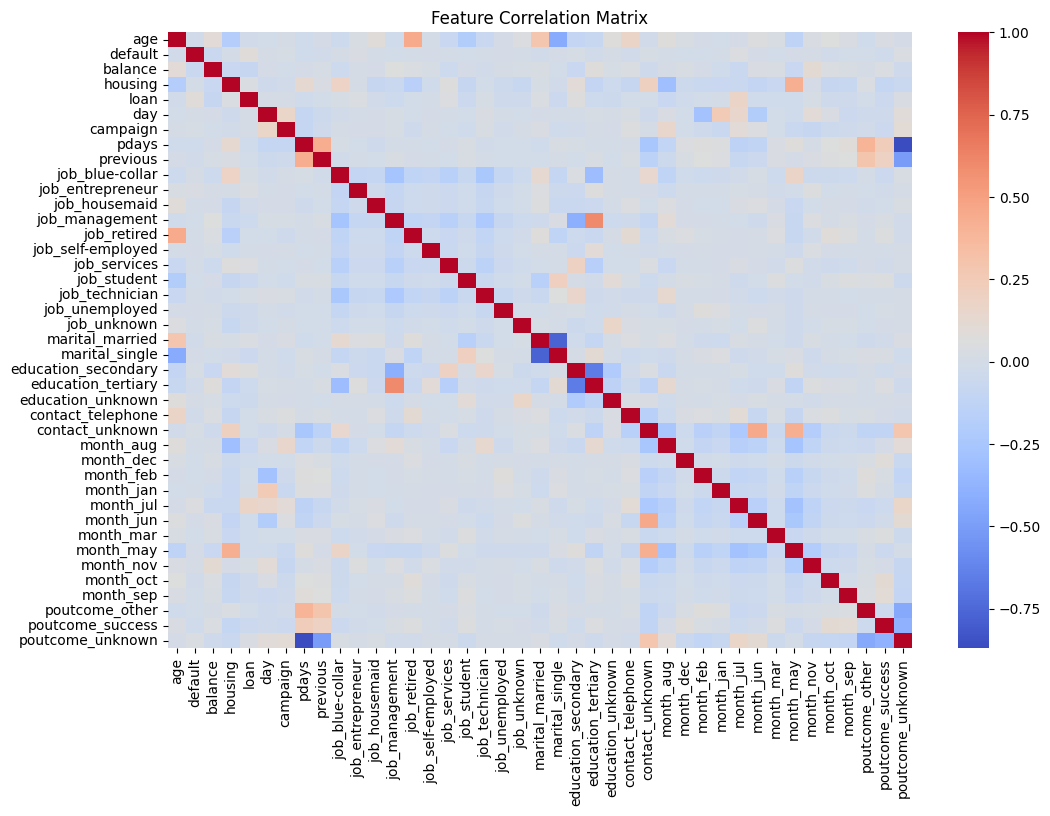

In [115]:
corr = pd.DataFrame(x_train).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

* The correlation matrix shows that most features exhibit weak linear correlations, indicating low multicollinearity within the dataset. This suggests that the features provide complementary information and supports the use of tree-based models, which can capture non-linear relationships without being affected by correlated inputs.

*  The low pairwise correlations indicate minimal redundancy among features, reducing the risk of multicollinearity and supporting the robustness of the trained models.

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [24]:
lr_test_pred = lr.predict(x_test_scaled)
lr_acc = lr.score(x_test_scaled, y_test)
print(lr_acc)

0.8944528001415554


In [25]:
lr_train_pred = lr.predict(x_train_scaled)
lr_train_acc = lr.score(x_train_scaled, y_train)
print(lr_train_acc)

0.8918249380677127


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9981
           1       0.68      0.19      0.29      1322

    accuracy                           0.89     11303
   macro avg       0.79      0.59      0.62     11303
weighted avg       0.88      0.89      0.87     11303



* the recall for the positive class (subscribers) is low, showing difficulty in identifying actual subscribers due to class imbalance.
* limited in capturing minority class behavior.

In [27]:
from sklearn.metrics import accuracy_score
if accuracy_score(y_train, lr_train_pred) > accuracy_score(y_test, lr_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, lr_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Good Fit


In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train_scaled, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [29]:
knn_test_pred = knn.predict(x_test_scaled)
knn_acc = knn.score(x_test_scaled, y_test)
print(knn_acc)

0.8904715562240113


In [30]:
knn_train_pred = knn.predict(x_train_scaled)
knn_train_acc = knn.score(x_train_scaled, y_train)
print(knn_train_acc)

0.9056564822460776


In [31]:
print(classification_report(y_test, knn_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9981
           1       0.57      0.26      0.36      1322

    accuracy                           0.89     11303
   macro avg       0.74      0.62      0.65     11303
weighted avg       0.87      0.89      0.87     11303



* performs well for the majority class, but shows moderate recall for the minority class compared to Logistic Regression.
* This suggests KNN can capture some local patterns but is sensitive to class imbalance and feature scaling.
* Not the best choice for this dataset.

In [32]:
if accuracy_score(y_train, knn_train_pred) > accuracy_score(y_test, knn_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, knn_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Good Fit


In [65]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(x_train_scaled, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [66]:
svm_test_pred = svm.predict(x_test_scaled)
svm_acc = svm.score(x_test_scaled, y_test)
print(svm_acc)

0.8952490489250642


In [67]:
svm_train_pred = svm.predict(x_train_scaled)
svm_train_acc = svm.score(x_train_scaled, y_train)
print(svm_train_acc)

0.9006134245605757


In [68]:
print(classification_report(y_test, svm_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9981
           1       0.67      0.20      0.31      1322

    accuracy                           0.90     11303
   macro avg       0.79      0.59      0.63     11303
weighted avg       0.88      0.90      0.87     11303



* recall for the positive class remains low, showing difficulty in identifying subscribers in an imbalanced dataset.
* SVM provides a strong margin-based baseline, but its minority class performance is similar to Logistic Regression and KNN, indicating limited ability to capture minority class behavior.

In [69]:
if accuracy_score(y_train, svm_train_pred) > accuracy_score(y_test, svm_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, svm_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Good Fit


In [117]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [39]:
rf_test_pred = rf.predict(x_test)
rf_acc = rf.score(x_test, y_test)
print(rf_acc)

0.8952490489250642


In [40]:
rf_train_pred = rf.predict(x_train)
rf_train_acc = rf.score(x_train, y_train)
print(rf_train_acc)

0.9999410168691755


In [41]:
print(classification_report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9981
           1       0.65      0.23      0.34      1322

    accuracy                           0.90     11303
   macro avg       0.78      0.61      0.64     11303
weighted avg       0.88      0.90      0.87     11303



* Based on the large train–test gap, the default Random Forest was classified as overfitted.

In [42]:
if accuracy_score(y_train, rf_train_pred) > accuracy_score(y_test, rf_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, rf_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Overfit


In [118]:
# To address overfitting, hyperparameters were tuned to control model complexity.

rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=12, # Limited tree depth using max_depth  
    min_samples_split=10, # increased min_samples_split 
    min_samples_leaf=5, # increased min_samples_leaf to prevent learning noise.
    class_weight='balanced', # Applied class weighting to handle class imbalance and improve minority class detection.
    random_state=42
)

rf_tuned.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [119]:
rf_tuned_test_pred = rf_tuned.predict(x_test)
rf_tuned_acc = rf_tuned.score(x_test, y_test)
print(rf_tuned_acc)

0.8288065115456074


In [120]:
rf_tuned_train_pred = rf_tuned.predict(x_train)
rf_tuned_train_acc = rf_tuned.score(x_train, y_train)
print(rf_tuned_train_acc)

0.8433408045299045


In [122]:
from sklearn.metrics import accuracy_score
if accuracy_score(y_train, rf_tuned_train_pred) > accuracy_score(y_test, rf_tuned_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, rf_tuned_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Good Fit


* The default Random Forest overfitted the data, so hyperparameter tuning was applied to control complexity and improve generalization.

In [44]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [45]:
xgb_test_pred = xgb.predict(x_test)
xgb_acc = xgb.score(x_test, y_test)
print(xgb_acc)

0.8948066884897815


In [46]:
xgb_train_pred = xgb.predict(x_train)
xgb_train_acc = xgb.score(x_train, y_train)
print(xgb_train_acc)

0.9257697298572608


* no severe overfitting.

In [47]:
print(classification_report(y_test, xgb_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9981
           1       0.61      0.27      0.38      1322

    accuracy                           0.89     11303
   macro avg       0.76      0.63      0.66     11303
weighted avg       0.88      0.89      0.88     11303



* performs very well for the majority class, similar to other models.
* Compared to Logistic Regression and SVM, XGBoost achieved better recall for the positive class, showing improved ability to identify subscribers.

In [48]:
if accuracy_score(y_train, xgb_train_pred) > accuracy_score(y_test, xgb_test_pred) + .1:
    print("Overfit")

elif accuracy_score(y_train, xgb_train_pred) < .60:
    print("Underfit")

else:
    print("Good Fit")

Good Fit


In [124]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score

def collect_metrics(name, model, X_tr, y_tr, X_te, y_te):
    return {
        "Model": name,
        "Train_ROC_AUC": roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1]),
        "Test_ROC_AUC": roc_auc_score(y_te, model.predict_proba(X_te)[:,1]), # Used ROC–AUC to measure overall classification performance, especially suitable for imbalanced data.
        "Recall_1": recall_score(y_te, model.predict(X_te)), # Calculated Recall for the positive class to evaluate how well the model identifies actual subscribers.
        "F1_1": f1_score(y_te, model.predict(X_te)) # Used F1-score to balance precision and recall for the minority class.
    }

# Defined a reusable evaluation function to compare all models using the same metrics.

In [125]:
rf_metrics = collect_metrics("Random Forest", rf_tuned, x_train, y_train, x_test, y_test)
rf_metrics

{'Model': 'Random Forest',
 'Train_ROC_AUC': 0.8600060077820302,
 'Test_ROC_AUC': 0.7955472432417358,
 'Recall_1': 0.5975794251134644,
 'F1_1': 0.44950213371266}

In [72]:
lr_metrics = collect_metrics("Logistic Regression", lr, x_train_scaled, y_train, x_test_scaled, y_test)
lr_metrics

{'Model': 'Logistic Regression',
 'Train_ROC_AUC': 0.7664040514869565,
 'Test_ROC_AUC': 0.7727541633187776,
 'Recall_1': 0.18532526475037822,
 'F1_1': 0.29114676173499704}

In [73]:
svm_metrics = collect_metrics("Support Vector Machine", svm, x_train_scaled, y_train, x_test_scaled, y_test)
svm_metrics

{'Model': 'Support Vector Machine',
 'Train_ROC_AUC': 0.8554904470683783,
 'Test_ROC_AUC': 0.7229853590202625,
 'Recall_1': 0.2027231467473525,
 'F1_1': 0.3116279069767442}

In [74]:
knn_metrics = collect_metrics("K-Nearest Neighbors", knn, x_train_scaled, y_train, x_test_scaled, y_test)
knn_metrics

{'Model': 'K-Nearest Neighbors',
 'Train_ROC_AUC': 0.9170324863837962,
 'Test_ROC_AUC': 0.7133784902358354,
 'Recall_1': 0.2617246596066566,
 'F1_1': 0.35854922279792745}

In [75]:
xgb_metrics = collect_metrics("XGBoost", xgb, x_train, y_train, x_test, y_test)
xgb_metrics

{'Model': 'XGBoost',
 'Train_ROC_AUC': 0.9183095084057717,
 'Test_ROC_AUC': 0.789116947010212,
 'Recall_1': 0.27382753403933435,
 'F1_1': 0.37846314688970206}

In [77]:
results_df = pd.DataFrame([lr_metrics, knn_metrics, svm_metrics, rf_metrics, xgb_metrics])

results_df.sort_values(by="Test_ROC_AUC", ascending=False)

,Model,Train_ROC_AUC,Test_ROC_AUC,Recall_1,F1_1
3,Random Forest,0.860006,0.795547,0.597579,0.449502
4,XGBoost,0.918310,0.789117,0.273828,0.378463
0,Logistic Regression,0.766404,0.772754,0.185325,0.291147
2,Support Vector Machine,0.855490,0.722985,0.202723,0.311628
1,K-Nearest Neighbors,0.917032,0.713378,0.261725,0.358549


Among all evaluated models, Random Forest achieved the best overall performance on the test set, with the highest ROC–AUC and significantly better recall and F1-score for the positive class. Since identifying potential subscribers is more important than overall accuracy in a marketing context, Random Forest was selected as the final model.

In [78]:
from sklearn.ensemble import RandomForestClassifier

final_model = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)

final_model.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [79]:
y_pred = final_model.predict(x_test)
y_prob = final_model.predict_proba(x_test)[:, 1]

In [81]:
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8288065115456074
ROC-AUC: 0.7955472432417358

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      9981
           1       0.36      0.60      0.45      1322

    accuracy                           0.83     11303
   macro avg       0.65      0.73      0.67     11303
weighted avg       0.87      0.83      0.85     11303



In [87]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[8578, 1403],
       [ 532,  790]])

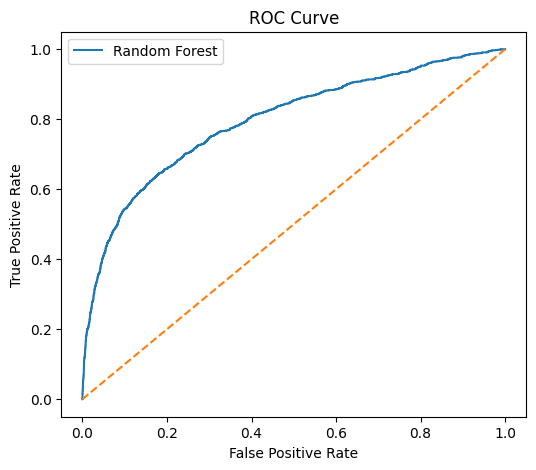

In [88]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Feature importance analysis was not emphasized because categorical variables were transformed using one-hot encoding, resulting in a large number of derived features. Interpreting importance at the individual dummy variable level would be misleading and would not accurately represent the influence of the original attributes

Hyperparameter Tuning

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [8, 12, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [8, 12, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [2, 5], 'min_samples_split': [5, 10], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and par

In [95]:
print("Best Parameters:")
print(grid_search.best_params_)

print("\nBest Cross-Validation ROC-AUC:")
print(grid_search.best_score_)

Best Parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}

Best Cross-Validation ROC-AUC:
0.7939195897322913


In [97]:
rf_tuned = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=5,
    min_samples_split=5
)

rf_tuned.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [98]:
rf_tuned_test_pred = rf_tuned.predict(x_test)
rf_tuned_acc = rf_tuned.score(x_test, y_test)   
print(rf_tuned_acc)

0.8665840927187473


In [99]:
rf_tunedd_train_pred = rf_tuned.predict(x_train)
rf_tunedd_train_acc = rf_tuned.score(x_train, y_train)
print(rf_tunedd_train_acc)

0.9042113955408753


In [100]:
y_pred = rf_tuned.predict(x_test)
y_prob = rf_tuned.predict_proba(x_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test ROC-AUC: 0.8005848025014548

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      9981
           1       0.44      0.53      0.48      1322

    accuracy                           0.87     11303
   macro avg       0.69      0.72      0.70     11303
weighted avg       0.88      0.87      0.87     11303



In [102]:
import joblib

joblib.dump(rf_tuned, "random_forest_model.pkl")

['random_forest_model.pkl']

In [103]:
joblib.dump(ohe, "onehot_encoder.pkl")

['onehot_encoder.pkl']

In [104]:
joblib.dump(x_train.columns.tolist(), "model_features.pkl")

['model_features.pkl']